## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [2]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [3]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [4]:
df_transactions['trans_date'] = pd.to_datetime(df_transactions['trans_date'],  format='%d-%b-%y')
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [5]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [6]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [7]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
 3   recent       125000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.8+ MB


In [8]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [9]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [10]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days, # AOU
                                                     })       

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [11]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


In [12]:
#Creating addtional variables 
df_transactions = df_transactions.sort_values(by=['customer_id','trans_date'])
df_transactions['last_trans_date'] = df_transactions.groupby('customer_id')['trans_date'].shift(1)
df_transactions['day_from_last_purchase'] = (df_transactions['trans_date']-df_transactions['last_trans_date']).dt.days
df_transactions.sort_values(by=['customer_id','trans_date'])

,customer_id,trans_date,tran_amount,recent,last_trans_date,day_from_last_purchase
77247,CS1112,2011-06-15,56,1371.0,NaT,NaN
89149,CS1112,2011-08-19,96,1306.0,2011-06-15,65.0
68206,CS1112,2011-10-02,60,1262.0,2011-08-19,44.0
36486,CS1112,2012-04-08,56,1073.0,2011-10-02,189.0
93074,CS1112,2012-06-24,52,996.0,2012-04-08,77.0
...,...,...,...,...,...,...
102102,CS9000,2014-01-12,16,429.0,2013-10-01,103.0
113120,CS9000,2014-05-08,20,313.0,2014-01-12,116.0
103039,CS9000,2014-07-08,26,252.0,2014-05-08,61.0
102384,CS9000,2014-08-24,35,205.0,2014-07-08,47.0


In [13]:
df_ticket_tbp = df_transactions.groupby('customer_id').agg(ticket_sd=('tran_amount','std'), ticket_mean=('tran_amount','mean'), MTBP=('day_from_last_purchase','mean'), SD_TBP=('day_from_last_purchase','std')).reset_index()
df_ticket_tbp['cv_ticket'] = df_ticket_tbp['ticket_sd']/df_ticket_tbp['ticket_mean']
df_ticket_tbp['cv_TBP'] = df_ticket_tbp['SD_TBP']/df_ticket_tbp['MTBP']
df_ticket_tbp

,customer_id,ticket_sd,ticket_mean,MTBP,SD_TBP,cv_ticket,cv_TBP
0,CS1112,19.766012,67.466667,93.500000,50.873523,0.292974,0.544102
1,CS1113,21.254102,74.500000,71.263158,54.685812,0.285290,0.767378
2,CS1114,21.341692,75.368421,72.722222,73.693168,0.283165,1.013351
3,CS1115,18.151896,75.409091,62.047619,55.413425,0.240712,0.893079
4,CS1116,22.940000,65.923077,96.250000,107.361010,0.347981,1.115439
...,...,...,...,...,...,...,...
6884,CS8996,18.749017,44.769231,93.333333,100.650912,0.418792,1.078403
6885,CS8997,14.000981,38.785714,85.846154,77.791223,0.360983,0.906170
6886,CS8998,22.319648,48.000000,107.750000,109.644985,0.464993,1.017587
6887,CS8999,15.453498,31.916667,97.545455,55.000661,0.484183,0.563846


In [14]:
df_clv = df_clv.merge(df_ticket_tbp, how='left',on='customer_id')
df_clv

,customer_id,recency,frequency,monetary_value,AOU,ticket_size,ticket_sd,ticket_mean,MTBP,SD_TBP,cv_ticket,cv_TBP
0,CS1112,62.0,15,1012,1309,67.466667,19.766012,67.466667,93.500000,50.873523,0.292974,0.544102
1,CS1113,36.0,20,1490,1354,74.500000,21.254102,74.500000,71.263158,54.685812,0.285290,0.767378
2,CS1114,33.0,19,1432,1309,75.368421,21.341692,75.368421,72.722222,73.693168,0.283165,1.013351
3,CS1115,12.0,22,1659,1303,75.409091,18.151896,75.409091,62.047619,55.413425,0.240712,0.893079
4,CS1116,204.0,13,857,1155,65.923077,22.940000,65.923077,96.250000,107.361010,0.347981,1.115439
...,...,...,...,...,...,...,...,...,...,...,...,...
6884,CS8996,98.0,13,582,1120,44.769231,18.749017,44.769231,93.333333,100.650912,0.418792,1.078403
6885,CS8997,262.0,14,543,1116,38.785714,14.000981,38.785714,85.846154,77.791223,0.360983,0.906170
6886,CS8998,85.0,13,624,1293,48.000000,22.319648,48.000000,107.750000,109.644985,0.464993,1.017587
6887,CS8999,258.0,12,383,1073,31.916667,15.453498,31.916667,97.545455,55.000661,0.484183,0.563846


In [15]:
combined_df = df_clv.merge(df_response, how='left', on='customer_id')
combined_df

,customer_id,recency,frequency,monetary_value,AOU,ticket_size,ticket_sd,ticket_mean,MTBP,SD_TBP,cv_ticket,cv_TBP,response
0,CS1112,62.0,15,1012,1309,67.466667,19.766012,67.466667,93.500000,50.873523,0.292974,0.544102,0.0
1,CS1113,36.0,20,1490,1354,74.500000,21.254102,74.500000,71.263158,54.685812,0.285290,0.767378,0.0
2,CS1114,33.0,19,1432,1309,75.368421,21.341692,75.368421,72.722222,73.693168,0.283165,1.013351,1.0
3,CS1115,12.0,22,1659,1303,75.409091,18.151896,75.409091,62.047619,55.413425,0.240712,0.893079,1.0
4,CS1116,204.0,13,857,1155,65.923077,22.940000,65.923077,96.250000,107.361010,0.347981,1.115439,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,CS8996,98.0,13,582,1120,44.769231,18.749017,44.769231,93.333333,100.650912,0.418792,1.078403,0.0
6885,CS8997,262.0,14,543,1116,38.785714,14.000981,38.785714,85.846154,77.791223,0.360983,0.906170,0.0
6886,CS8998,85.0,13,624,1293,48.000000,22.319648,48.000000,107.750000,109.644985,0.464993,1.017587,0.0
6887,CS8999,258.0,12,383,1073,31.916667,15.453498,31.916667,97.545455,55.000661,0.484183,0.563846,0.0


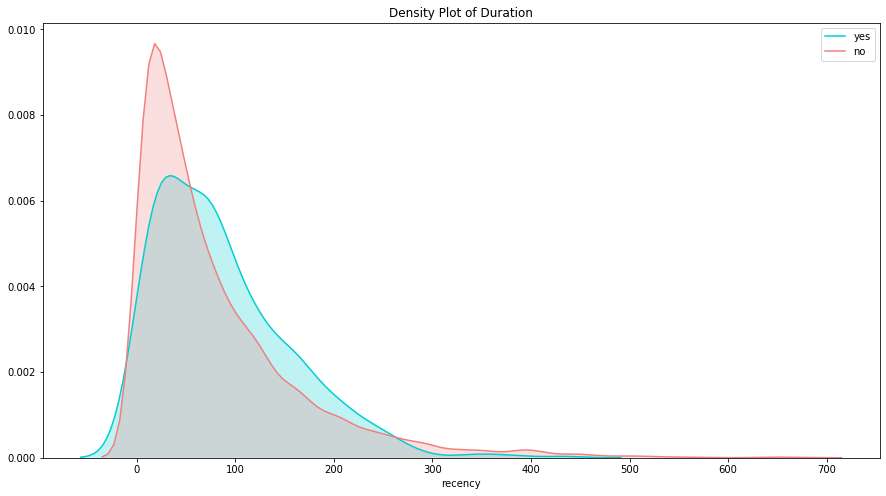

In [16]:
#recency
plt.figure(figsize=(15,8))
ax = sns.kdeplot(combined_df["recency"][combined_df['response'] == 1], color="darkturquoise", shade=True)
sns.kdeplot(combined_df["recency"][combined_df['response'] == 0], color="lightcoral", shade=True)
plt.legend(['yes', 'no'])
plt.title('Density Plot of Duration')
ax.set(xlabel='recency')
# plt.xlim(-10,5000)
plt.show()

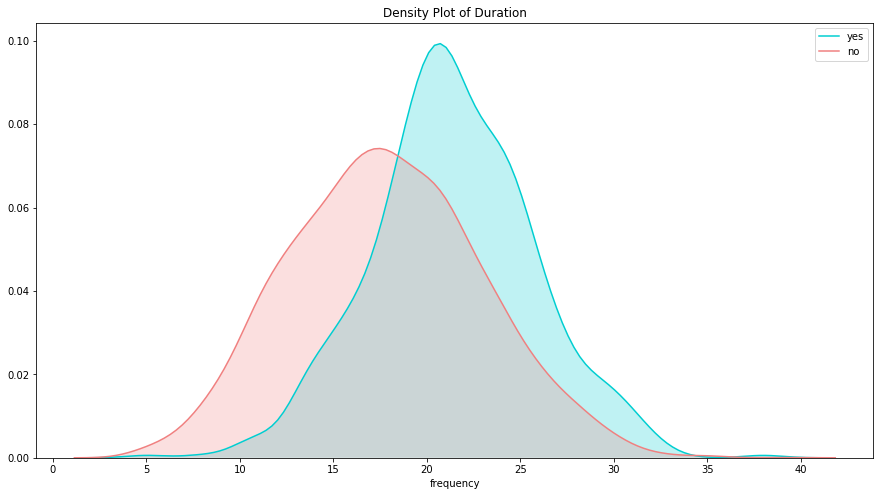

In [17]:
#frequency
plt.figure(figsize=(15,8))
ax = sns.kdeplot(combined_df["frequency"][combined_df['response'] == 1], color="darkturquoise", shade=True)
sns.kdeplot(combined_df["frequency"][combined_df['response'] == 0], color="lightcoral", shade=True)
plt.legend(['yes', 'no'])
plt.title('Density Plot of Duration')
ax.set(xlabel='frequency')
plt.show()

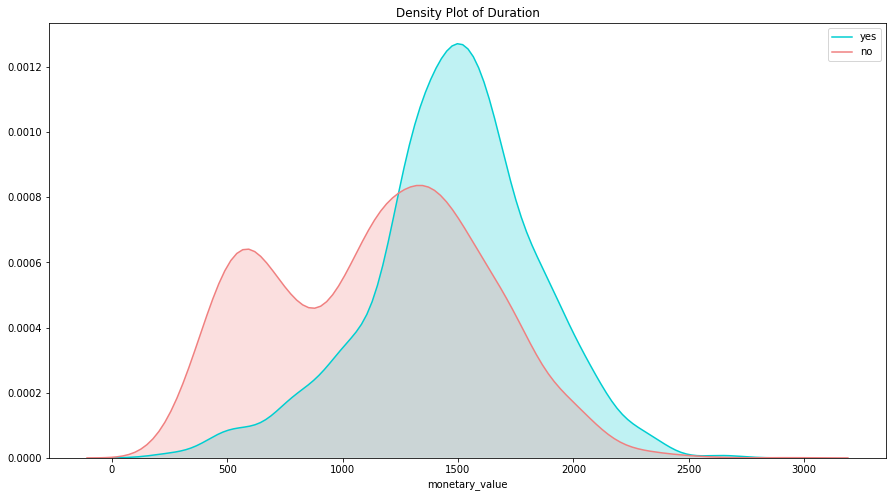

In [18]:
#monetary_value
plt.figure(figsize=(15,8))
ax = sns.kdeplot(combined_df["monetary_value"][combined_df['response'] == 1], color="darkturquoise", shade=True)
sns.kdeplot(combined_df["monetary_value"][combined_df['response'] == 0], color="lightcoral", shade=True)
plt.legend(['yes', 'no'])
plt.title('Density Plot of Duration')
ax.set(xlabel='monetary_value')
plt.show()

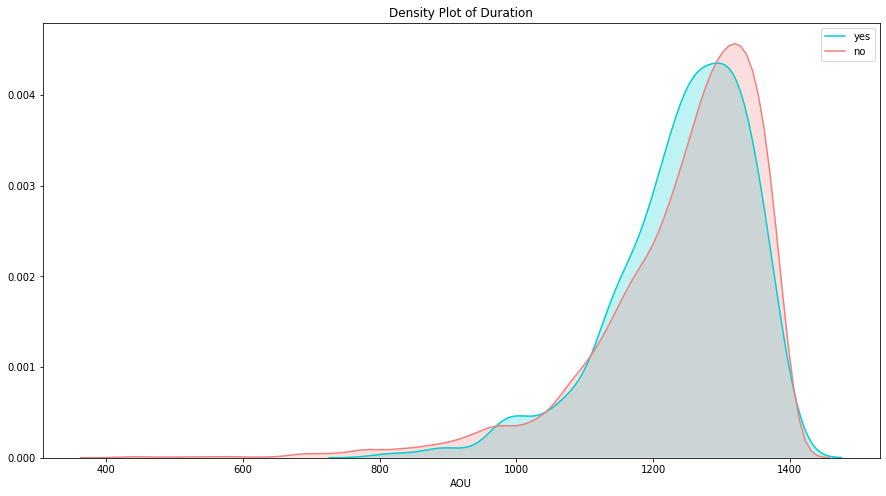

In [19]:
#'AOU'
plt.figure(figsize=(15,8))
ax = sns.kdeplot(combined_df['AOU'][combined_df['response'] == 1], color="darkturquoise", shade=True)
sns.kdeplot(combined_df['AOU'][combined_df['response'] == 0], color="lightcoral", shade=True)
plt.legend(['yes', 'no'])
plt.title('Density Plot of Duration')
ax.set(xlabel='AOU')
plt.show()

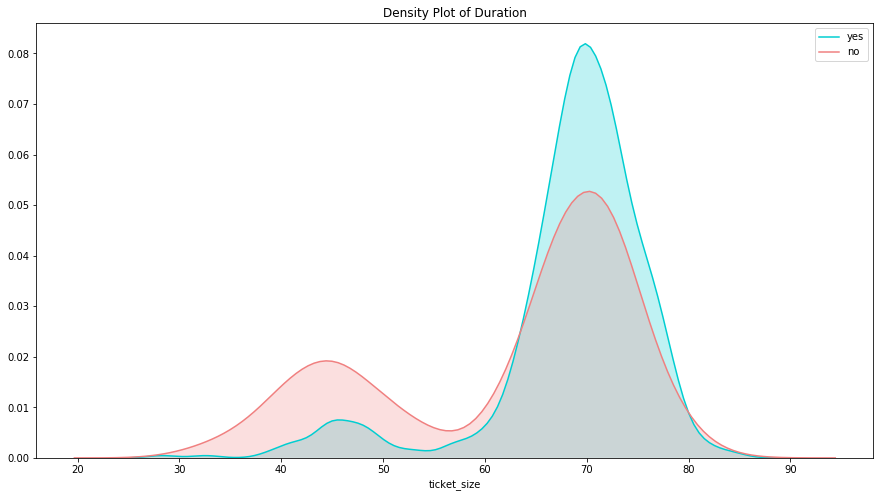

In [20]:
#ticket_size
plt.figure(figsize=(15,8))
ax = sns.kdeplot(combined_df['ticket_size'][combined_df['response'] == 1], color="darkturquoise", shade=True)
sns.kdeplot(combined_df['ticket_size'][combined_df['response'] == 0], color="lightcoral", shade=True)
plt.legend(['yes', 'no'])
plt.title('Density Plot of Duration')
ax.set(xlabel='ticket_size')
plt.show()

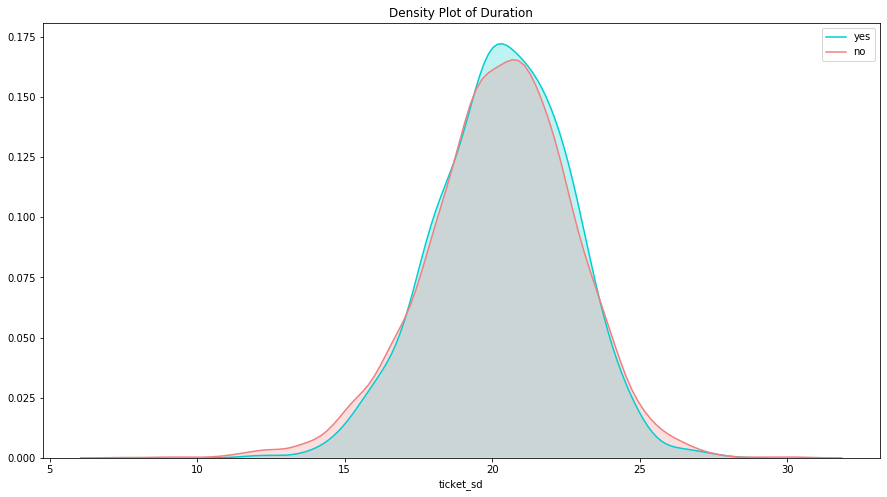

In [21]:
#ticket_sd
plt.figure(figsize=(15,8))
ax = sns.kdeplot(combined_df['ticket_sd'][combined_df['response'] == 1], color="darkturquoise", shade=True)
sns.kdeplot(combined_df['ticket_sd'][combined_df['response'] == 0], color="lightcoral", shade=True)
plt.legend(['yes', 'no'])
plt.title('Density Plot of Duration')
ax.set(xlabel='ticket_sd')
plt.show()

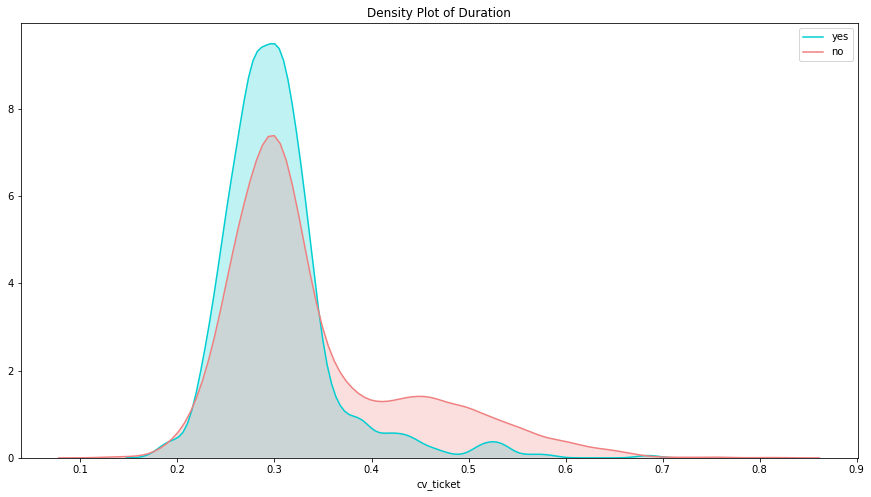

In [22]:
#cv_ticket
plt.figure(figsize=(15,8))
ax = sns.kdeplot(combined_df['cv_ticket'][combined_df['response'] == 1], color="darkturquoise", shade=True)
sns.kdeplot(combined_df['cv_ticket'][combined_df['response'] == 0], color="lightcoral", shade=True)
plt.legend(['yes', 'no'])
plt.title('Density Plot of Duration')
ax.set(xlabel='cv_ticket')
plt.show()

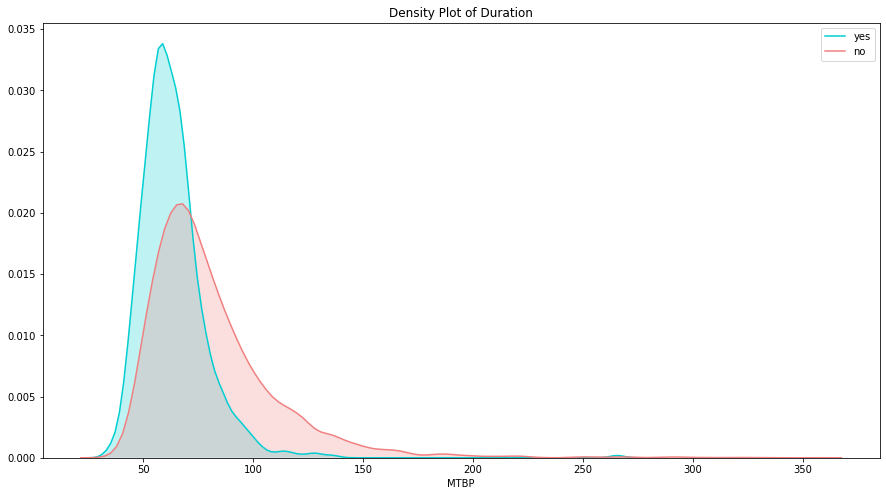

In [23]:
#MTBP
plt.figure(figsize=(15,8))
ax = sns.kdeplot(combined_df['MTBP'][combined_df['response'] == 1], color="darkturquoise", shade=True)
sns.kdeplot(combined_df['MTBP'][combined_df['response'] == 0], color="lightcoral", shade=True)
plt.legend(['yes', 'no'])
plt.title('Density Plot of Duration')
ax.set(xlabel='MTBP')
plt.show()

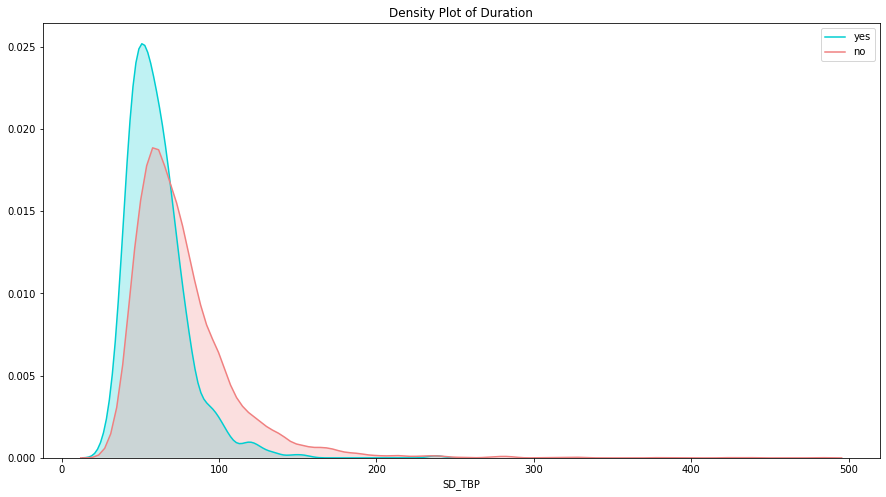

In [24]:
#SD_TBP
plt.figure(figsize=(15,8))
ax = sns.kdeplot(combined_df['SD_TBP'][combined_df['response'] == 1], color="darkturquoise", shade=True)
sns.kdeplot(combined_df['SD_TBP'][combined_df['response'] == 0], color="lightcoral", shade=True)
plt.legend(['yes', 'no'])
plt.title('Density Plot of Duration')
ax.set(xlabel='SD_TBP')
plt.show()

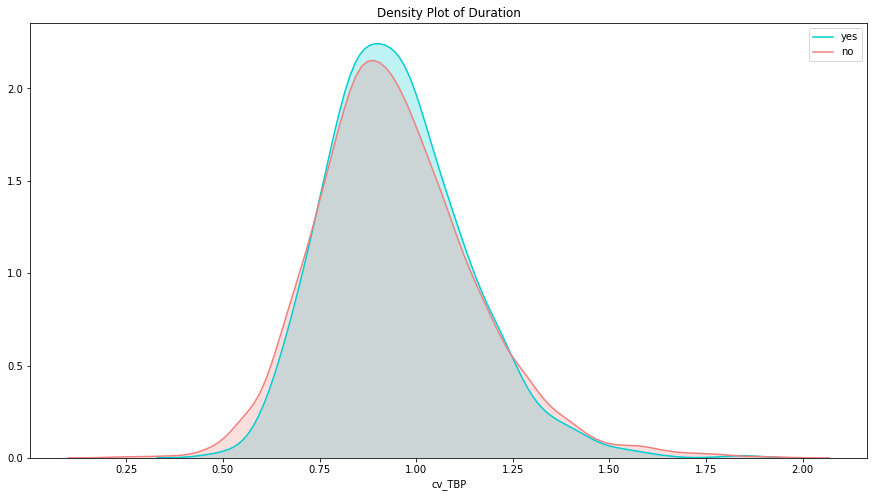

In [25]:
#cv_TBP
plt.figure(figsize=(15,8))
ax = sns.kdeplot(combined_df['cv_TBP'][combined_df['response'] == 1], color="darkturquoise", shade=True)
sns.kdeplot(combined_df['cv_TBP'][combined_df['response'] == 0], color="lightcoral", shade=True)
plt.legend(['yes', 'no'])
plt.title('Density Plot of Duration')
ax.set(xlabel='cv_TBP')
plt.show()

In [26]:
combined_df.columns

Index(['customer_id', 'recency', 'frequency', 'monetary_value', 'AOU',
       'ticket_size', 'ticket_sd', 'ticket_mean', 'MTBP', 'SD_TBP',
       'cv_ticket', 'cv_TBP', 'response'],
      dtype='object')

In [27]:
#selecting columns to be trained
df_modeling_clv = combined_df[['customer_id', 
                        'recency', 
                        'frequency', 
                        'monetary_value', 
                        # 'AOU',
                        'ticket_size', 
                        # 'ticket_sd', 
                        'ticket_mean', 
                        'MTBP',
                        'SD_TBP',
                        'cv_ticket', 
                        # 'cv_TBP', 
                        'response']]
df_modeling_clv

,customer_id,recency,frequency,monetary_value,ticket_size,ticket_mean,MTBP,SD_TBP,cv_ticket,response
0,CS1112,62.0,15,1012,67.466667,67.466667,93.500000,50.873523,0.292974,0.0
1,CS1113,36.0,20,1490,74.500000,74.500000,71.263158,54.685812,0.285290,0.0
2,CS1114,33.0,19,1432,75.368421,75.368421,72.722222,73.693168,0.283165,1.0
3,CS1115,12.0,22,1659,75.409091,75.409091,62.047619,55.413425,0.240712,1.0
4,CS1116,204.0,13,857,65.923077,65.923077,96.250000,107.361010,0.347981,1.0
...,...,...,...,...,...,...,...,...,...,...
6884,CS8996,98.0,13,582,44.769231,44.769231,93.333333,100.650912,0.418792,0.0
6885,CS8997,262.0,14,543,38.785714,38.785714,85.846154,77.791223,0.360983,0.0
6886,CS8998,85.0,13,624,48.000000,48.000000,107.750000,109.644985,0.464993,0.0
6887,CS8999,258.0,12,383,31.916667,31.916667,97.545455,55.000661,0.484183,0.0


In [28]:
df_modeling_clv = df_modeling_clv[~(df_modeling_clv['response'].isnull())]
df_modeling_clv.isnull().sum()

customer_id       0
recency           0
frequency         0
monetary_value    0
ticket_size       0
ticket_mean       0
MTBP              0
SD_TBP            0
cv_ticket         0
response          0
dtype: int64

## **Calculating response rate**

In [29]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


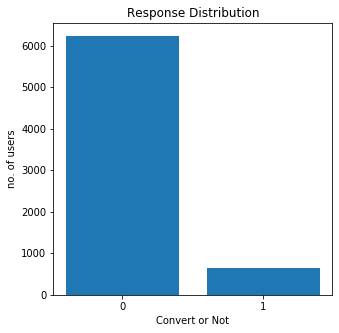

In [30]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [31]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


In [32]:
## merging two data sets - CLV

# df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,recency,frequency,monetary_value,ticket_size,ticket_mean,MTBP,SD_TBP,cv_ticket,response
0,CS1112,62.0,15,1012,67.466667,67.466667,93.500000,50.873523,0.292974,0.0
1,CS1113,36.0,20,1490,74.500000,74.500000,71.263158,54.685812,0.285290,0.0
2,CS1114,33.0,19,1432,75.368421,75.368421,72.722222,73.693168,0.283165,1.0
3,CS1115,12.0,22,1659,75.409091,75.409091,62.047619,55.413425,0.240712,1.0
4,CS1116,204.0,13,857,65.923077,65.923077,96.250000,107.361010,0.347981,1.0


## **Creating train and test dataset**

In [72]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [73]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

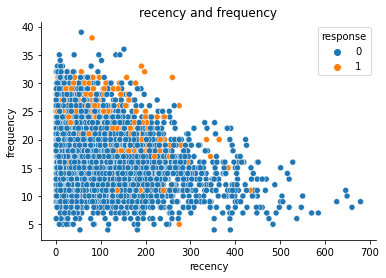

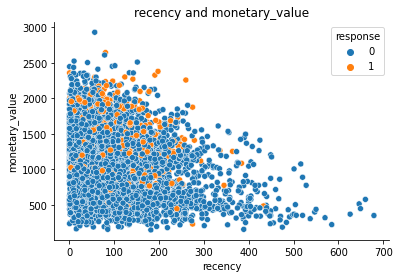

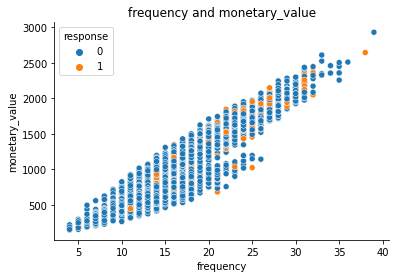

In [64]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

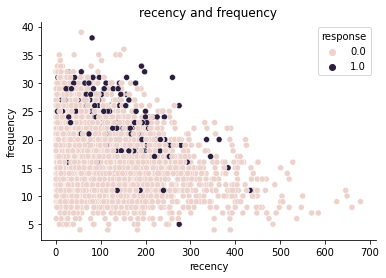

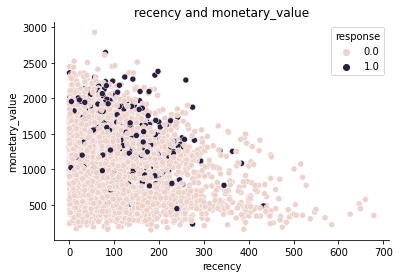

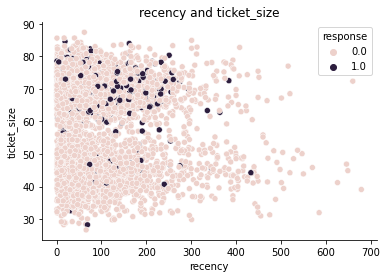

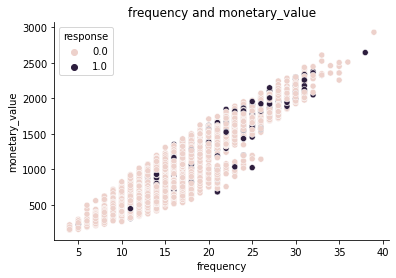

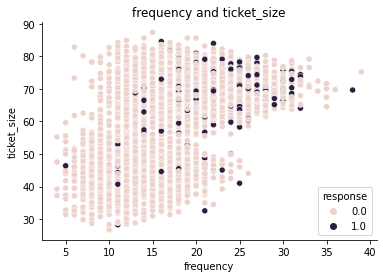

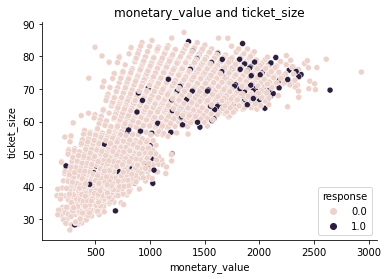

In [66]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value',  'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value',  'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [74]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_sample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_sample(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression**

In [75]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4389
           1       0.65      0.71      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

         0.0       0.95      0.63      0.75      1848
         1.0       0.18      0.71      0.29       218

    accuracy                           0.64      2066
   macro avg       0.57      0.67      0.52      2066
weighted avg       0.87      0.64      0.71      2066



In [76]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

         0.0       0.70      0.57      0.63      4389
         1.0       0.64      0.76      0.69      4389

    accuracy                           0.66      8778
   macro avg       0.67      0.66      0.66      8778
weighted avg       0.67      0.66      0.66      8778

test set
              precision    recall  f1-score   support

         0.0       0.96      0.57      0.71      1848
         1.0       0.18      0.82      0.30       218

    accuracy                           0.59      2066
   macro avg       0.57      0.69      0.51      2066
weighted avg       0.88      0.59      0.67      2066



## **XGBoost**

In [77]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.567615
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.713189
[2]	validation_0-auc:0.709773
[3]	validation_0-auc:0.69828
[4]	validation_0-auc:0.711449
[5]	validation_0-auc:0.713189
[6]	validation_0-auc:0.708296
Stopping. Best iteration:
[1]	validation_0-auc:0.713189

training set
              precision    recall  f1-score   support

           0       0.75      0.57      0.65      4389
           1       0.65      0.81      0.72      4389

    accuracy                           0.69      8778
   macro avg       0.70      0.69      0.69      8778
weighted avg       0.70      0.69      0.69      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.57      0.71      1848
           1       0.18      0.79      0.29       218

    accuracy                           0.59      2066
   macro avg       0.57      0.68      0.50      2066
weighted avg       0.88 

In [83]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=5,
 gamma=0.1,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.702371
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.69986
[2]	validation_0-auc:0.700862
[3]	validation_0-auc:0.699469
[4]	validation_0-auc:0.698563
[5]	validation_0-auc:0.703992
[6]	validation_0-auc:0.706976
[7]	validation_0-auc:0.707522
[8]	validation_0-auc:0.709671
[9]	validation_0-auc:0.711092
[10]	validation_0-auc:0.711378
[11]	validation_0-auc:0.713659
[12]	validation_0-auc:0.712659
[13]	validation_0-auc:0.71489
[14]	validation_0-auc:0.714598
[15]	validation_0-auc:0.714809
[16]	validation_0-auc:0.714467
[17]	validation_0-auc:0.714131
[18]	validation_0-auc:0.713656
Stopping. Best iteration:
[13]	validation_0-auc:0.71489

training set
              precision    recall  f1-score   support

         0.0       0.85      0.61      0.71      4389
         1.0       0.70      0.89      0.78      4389

    accuracy                           0.75      8778
   macro avg       0.77      0.75      0.75   

In [80]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [84]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 500],
    'clf__learning_rate': [0.01, 0.5],
    'clf__max_depth': range(2, 10),
    'clf__min_child_weight': range(1, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 21.3min


KeyboardInterrupt: ignored

In [85]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7128546168031679
[[1076  772]
 [  52  166]]
test set
              precision    recall  f1-score   support

         0.0       0.95      0.58      0.72      1848
         1.0       0.18      0.76      0.29       218

    accuracy                           0.60      2066
   macro avg       0.57      0.67      0.51      2066
weighted avg       0.87      0.60      0.68      2066



In [ ]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7f30bb15e0e0>}


# Try Undersampling

In [86]:
rus = RandomUnderSampler(random_state=0)

rus.fit(X_train_clv, y_train_clv)
X_under_clv, y_under_clv = rus.fit_resample(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [126]:
print('XGBoost model - Undersampling CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.11,
 n_estimators=500,
 max_depth=5,
 gamma=0.9,
 colsample_bytree=0.7,
 min_child_weight = 4 )

predicted_y = []
expected_y = []

xgb_model_under_clv = xgb_model.fit(X_under_clv, y_under_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_under_clv.predict(X_under_clv)
predictions_train =  xgb_model_under_clv.predict_proba(X_under_clv)
predicted_y.extend(predictions)
expected_y.extend(y_under_clv)
report_train = classification_report(expected_y, predicted_y)
train_auc = roc_auc_score(y_under_clv,  predictions_train[:,1])
print('training set')
print(report_train) 
print(f'Train AUC score: {train_auc}')

predicted_y = []
expected_y = []
predictions = xgb_model_under_clv.predict(X_test_clv.to_numpy())
predictions_test = xgb_model_under_clv.predict_proba(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
test_auc = roc_auc_score(y_test_clv, predictions_test[:,1])
print(f'Test AUC score: {test_auc}')

XGBoost model - Undersampling CLV
[0]	validation_0-auc:0.714477
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.745228
[2]	validation_0-auc:0.746252
[3]	validation_0-auc:0.744321
[4]	validation_0-auc:0.739588
[5]	validation_0-auc:0.734615
[6]	validation_0-auc:0.733579
[7]	validation_0-auc:0.728626
Stopping. Best iteration:
[2]	validation_0-auc:0.746252

training set
              precision    recall  f1-score   support

         0.0       0.79      0.65      0.71       429
         1.0       0.70      0.83      0.76       429

    accuracy                           0.74       858
   macro avg       0.75      0.74      0.74       858
weighted avg       0.75      0.74      0.74       858

Train AUC score: 0.8274216071418867
test set
              precision    recall  f1-score   support

         0.0       0.96      0.54      0.69      1848
         1.0       0.17      0.83      0.29       218

    accuracy                           0.57      2066
   